In [1]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from dynamics_env.dynamics_ma import Dynamics
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15
import pandas as pd

In [2]:
file_name = 'two_body_kilo'

In [3]:
results_file = f'runs/Dynamics-v0__{file_name}_best_performers.csv'

In [4]:
init_params = [0.48813504, 2.15189366, 1.02763376, 2.69299098, 4.58071204, 8.75364678]
device = torch.device('cuda' if torch.cuda.is_available and False else 'cpu')
seed = 0
M = 10
orbit_timesteps = 1000
orbit_duration = 10000 # Myr

In [5]:
def make_env(seed):
        def thunk():
            env = Dynamics(hyperparameters={
                'stationary_potential_list':[],
                'stationary_potential_kwargs_list':[],
                'dynamic_potential_list':['point_source','point_source'],
                'dynamic_potential_kwargs_list':[{'M':1e4}, {'M':1e4}],
                'seed':seed,
                'box_scaling':1,
            })
            env.action_space.seed(seed)
            env.observation_space.seed(seed)
            return env
        return thunk
env = make_env(seed=seed)()

def plot_from_init(init_params):
    env.reset()
    _, reward, _, _, info = env.step(init_params)
    orbit = info['orbit']
    orbit_delta = info['orbit_delta']
    reverse_orbit_init_params = orbit.y[:,-1]
    reverse_orbit_delta_init_params = orbit_delta.y[:,-1]
    reverse_orbit = env.reverse_leapfrog_verlet(env.get_acceleration, t_span=(0, env.orbit_duration), y0=reverse_orbit_init_params, delta_t=env.orbit_duration / env.orbit_timesteps)
    reverse_orbit_delta = env.reverse_leapfrog_verlet(env.get_acceleration, t_span=(0, env.orbit_duration), y0=reverse_orbit_delta_init_params, delta_t=env.orbit_duration / env.orbit_timesteps)
    fig = plt.figure(figsize=(30, 10))
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    for agent in range(env.num_agents):
        ax1.plot(orbit.y[agent*6], orbit.y[agent*6+1], orbit.y[agent*6+2], lw=0.5, label=r'$O_%d$'%agent)
        ax1.plot(orbit_delta.y[agent*6], orbit_delta.y[agent*6+1], orbit_delta.y[agent*6+2], lw=0.5, label=r'$O_{\delta%d}$'%agent)
        ax1.scatter(orbit.y[agent*6+0][0], orbit.y[agent*6+1][0], orbit.y[agent*6+2][0], label='Trajectory %d start'%agent)
    ax2 = fig.add_subplot(132)
    
    # ax2.scatter(0, 0, label='Source')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title('Projected Orbit')
    for agent in range(env.num_agents):
        ax2.plot(orbit.y[agent*6+0], orbit.y[agent*6+1], lw=2, label=r'$O_%d$'%agent)
        ax2.plot(orbit_delta.y[agent*6+0], orbit_delta.y[agent*6+1], lw=2, label=r'$O_{\delta%d}$'%agent)
        ax2.scatter(orbit.y[agent*6+0][0], orbit.y[agent*6+1][0], label='Trajectory %d start'%agent)
    ax1.set_title(f'3D Orbit')

    ax3 = fig.add_subplot(133)
    ax3.plot((orbit.y-reverse_orbit.y).sum(axis=0))
    ax3.set_title(f'Orbit-reverse-orbit distances: {(orbit.y - reverse_orbit.y).sum()}')
        
    print(reward)
    print(init_params)
    ax1.legend()
    ax2.legend()
    # ax3.legend()

[ENV] Using cpu
[ENV] Seed set to 0


Text(0.5, 1.0, 'Initial positions studied, projected on the XY plane')

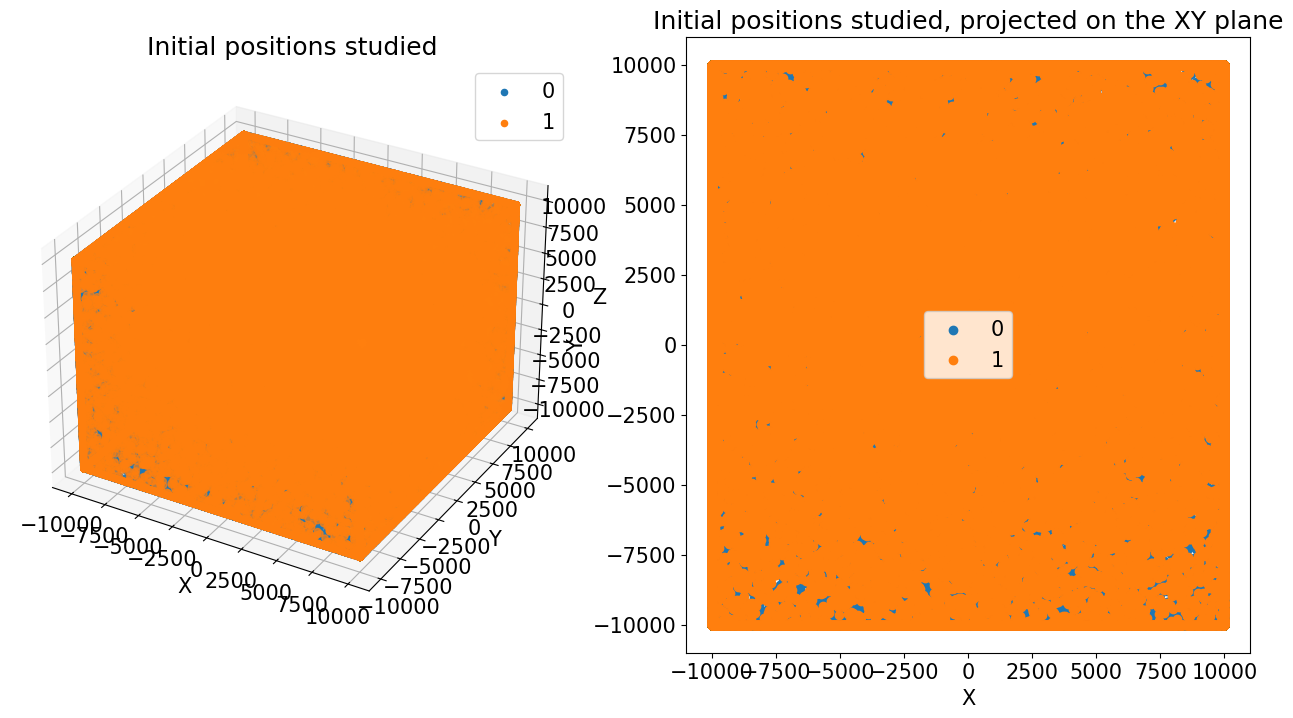

In [6]:
results = pd.read_csv(results_file).sort_values(by=['reward'], ascending=False)
result_init_params = {i:results.iloc[:, [j for j in range(i * 6+1, (i+1) * 6 + 1)]].to_numpy().transpose() for i in range(env.num_agents)}
result_init_params['reward'] = results.loc[:,'reward'].to_numpy()
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
for agent in range(env.num_agents):
    ax1.scatter(result_init_params[agent][0], result_init_params[agent][1], result_init_params[agent][2], label='%d'%agent)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.legend()
ax1.set_title('Initial positions studied')

ax2 = fig.add_subplot(122)
for agent in range(env.num_agents):
    ax2.scatter(result_init_params[agent][0], result_init_params[agent][1], label='%d'%agent)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.legend()
ax2.set_title('Initial positions studied, projected on the XY plane')

In [7]:
def result_to_init(i):
    return {agent:result_init_params[agent][:,i] for agent in range(env.num_agents)}

{0: np.float64(1.2100533444789829e-05), 1: np.float64(1.2111944758304192e-05)}
{0: array([ 10000.        ,  10000.        , -10000.        ,  -1000.        ,
         -280.25286865,   -313.31057739]), 1: array([ 10000.        ,  10000.        , -10000.        ,    142.64515686,
         -961.19494629,  -1000.        ])}


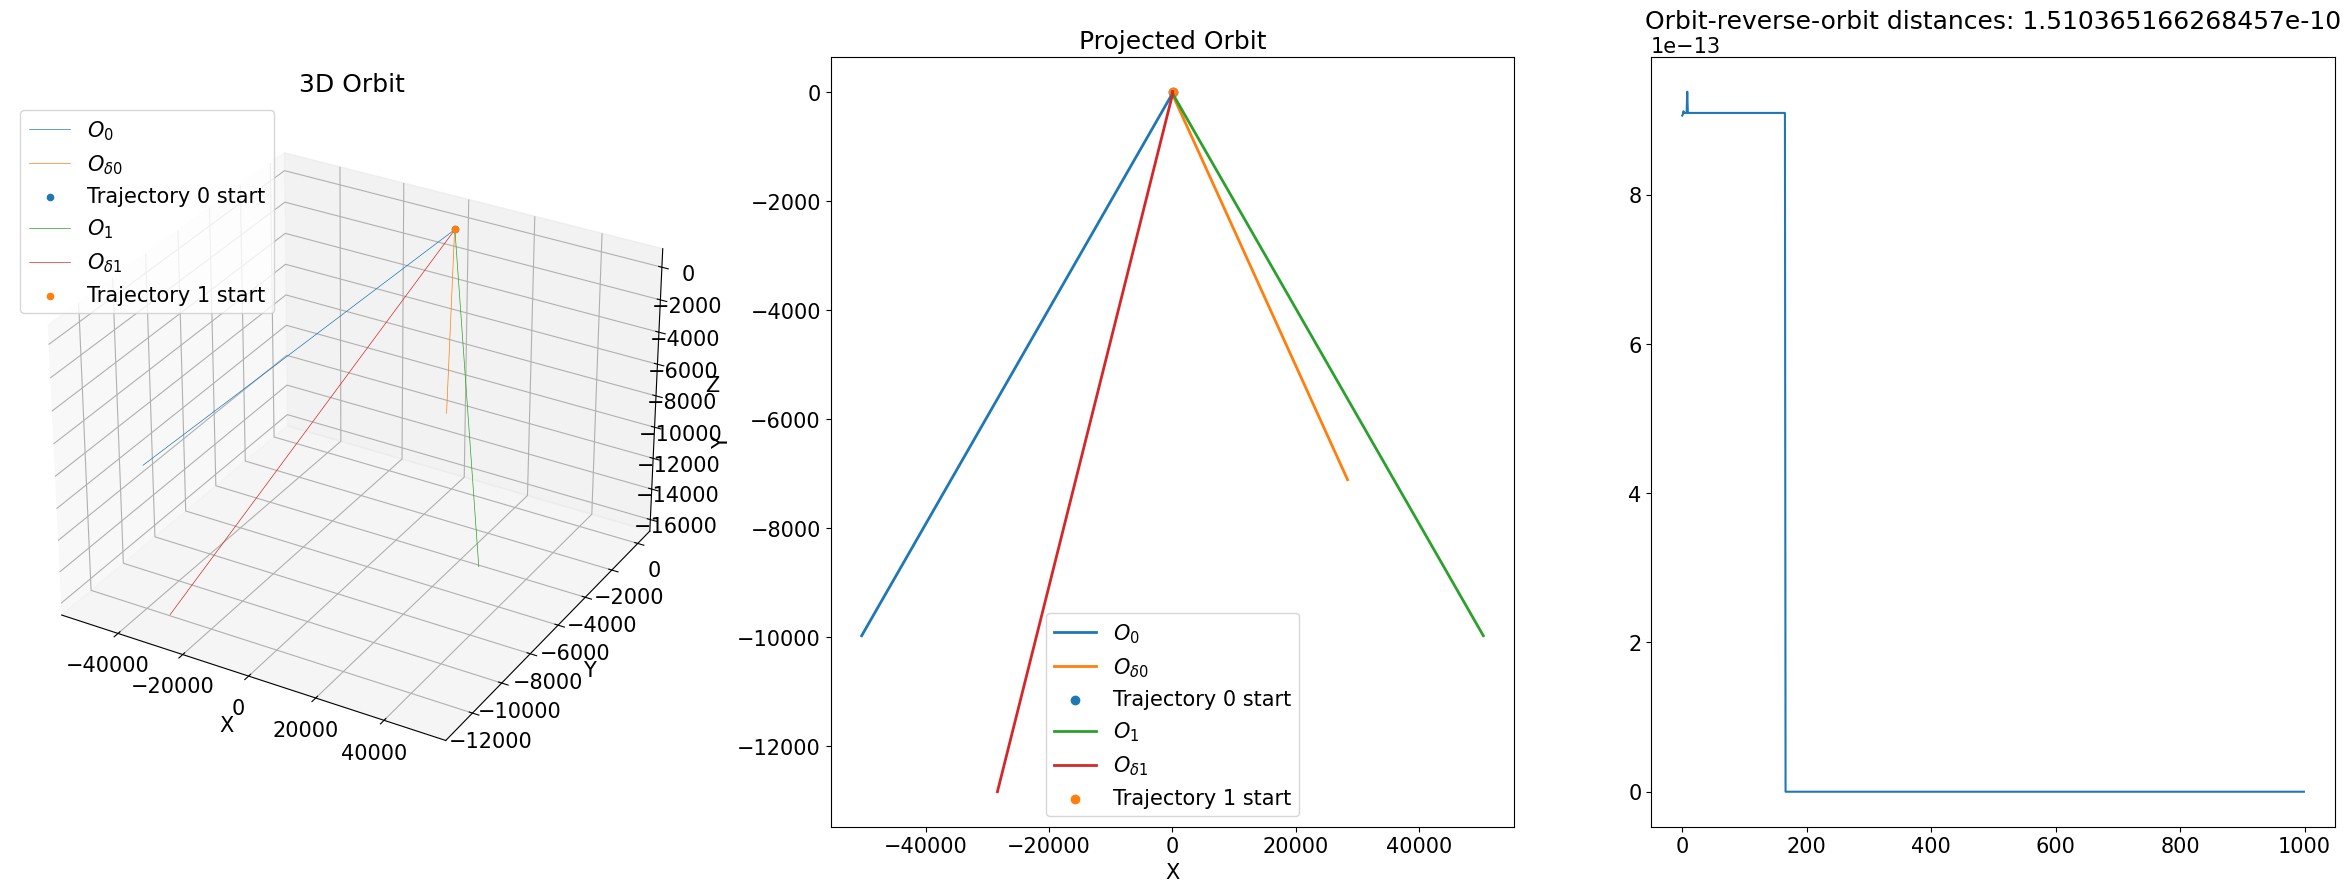

In [8]:
plot_from_init(result_to_init(0))

{0: np.float64(1.2059410009293058e-05), 1: np.float64(1.205134896476087e-05)}
{0: array([-10000.        , -10000.        ,  10000.        ,    583.03796387,
         1000.        ,    309.91064453]), 1: array([-10000.        , -10000.        ,  10000.        ,     92.77017975,
         -214.3433075 ,   -196.60493469])}


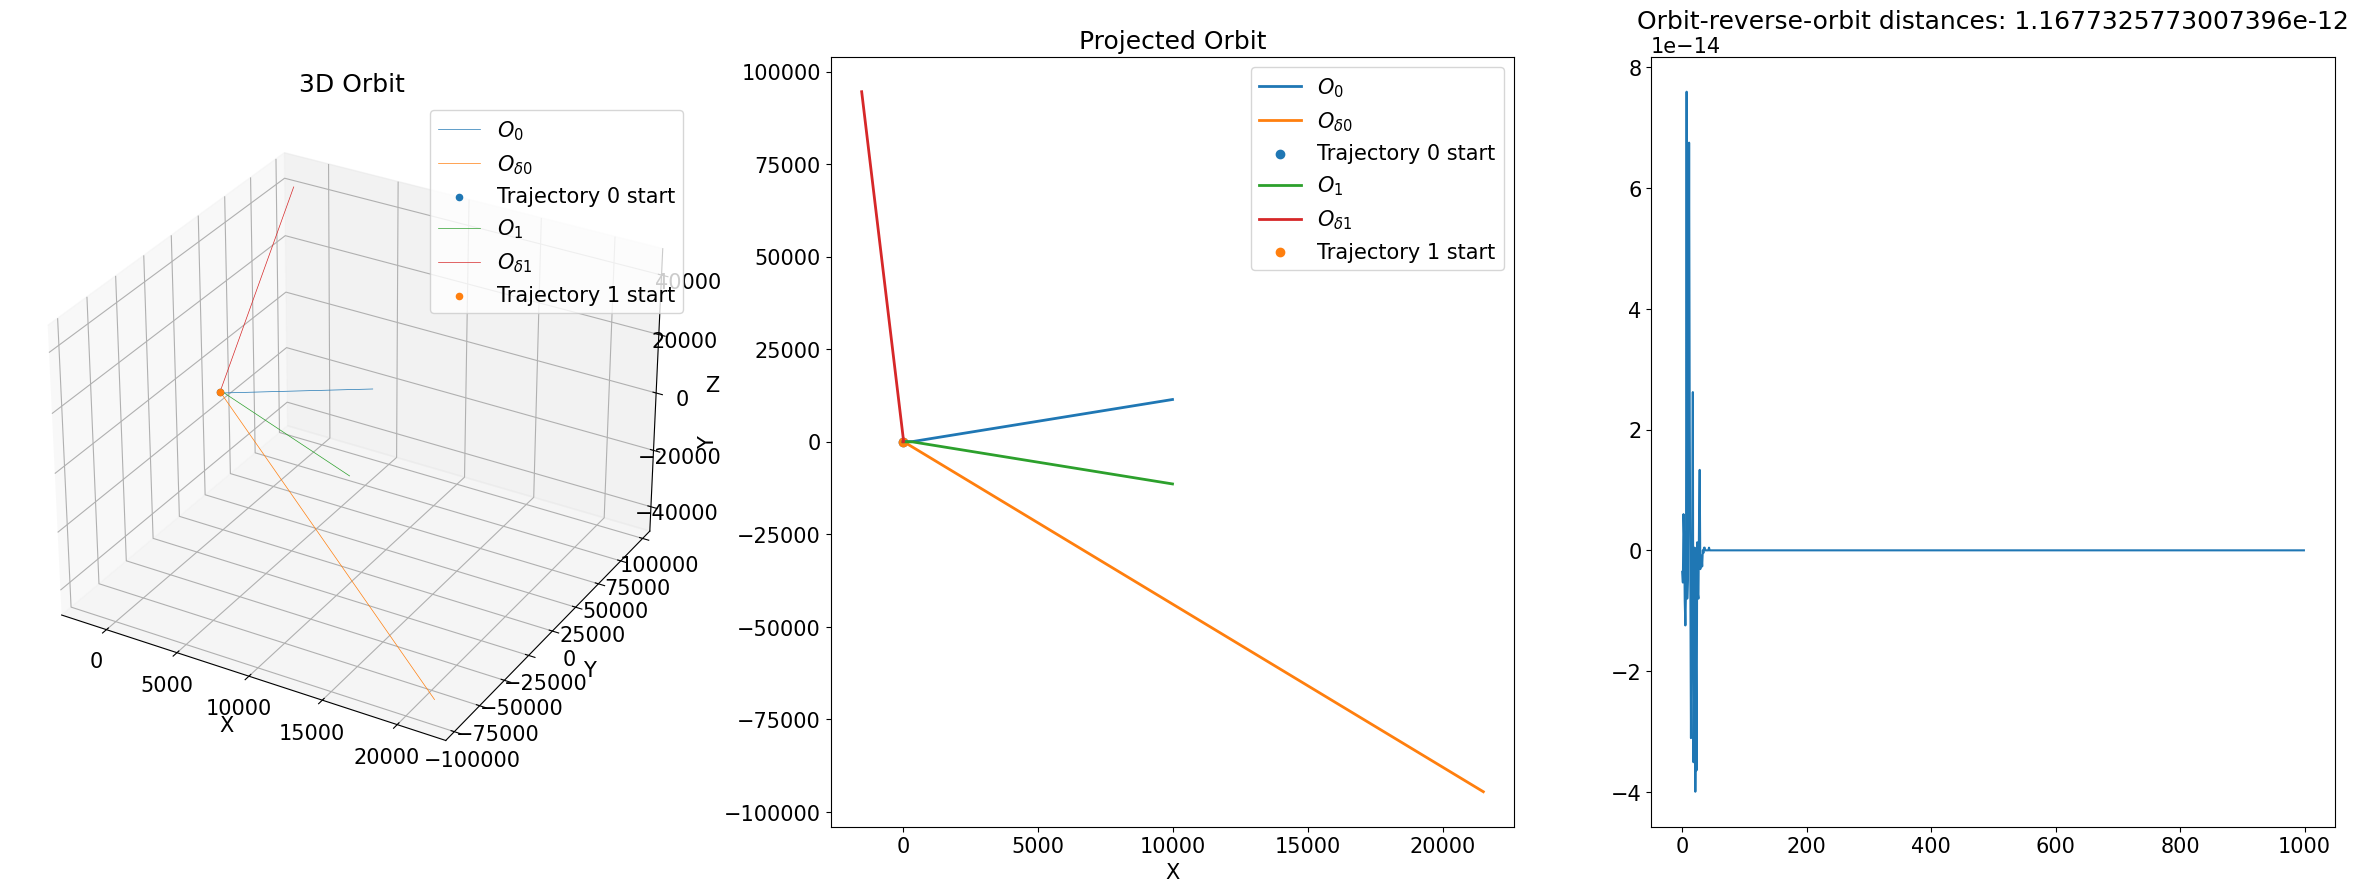

In [9]:
plot_from_init(result_to_init(1))

{0: np.float64(1.1965763097921136e-05), 1: np.float64(1.1972678659488746e-05)}
{0: array([ 10000.        ,  10000.        , -10000.        ,  -1000.        ,
         -127.57359314,    687.47961426]), 1: array([ 10000.        ,  10000.        , -10000.        ,   -670.71337891,
        -1000.        ,   -199.44766235])}


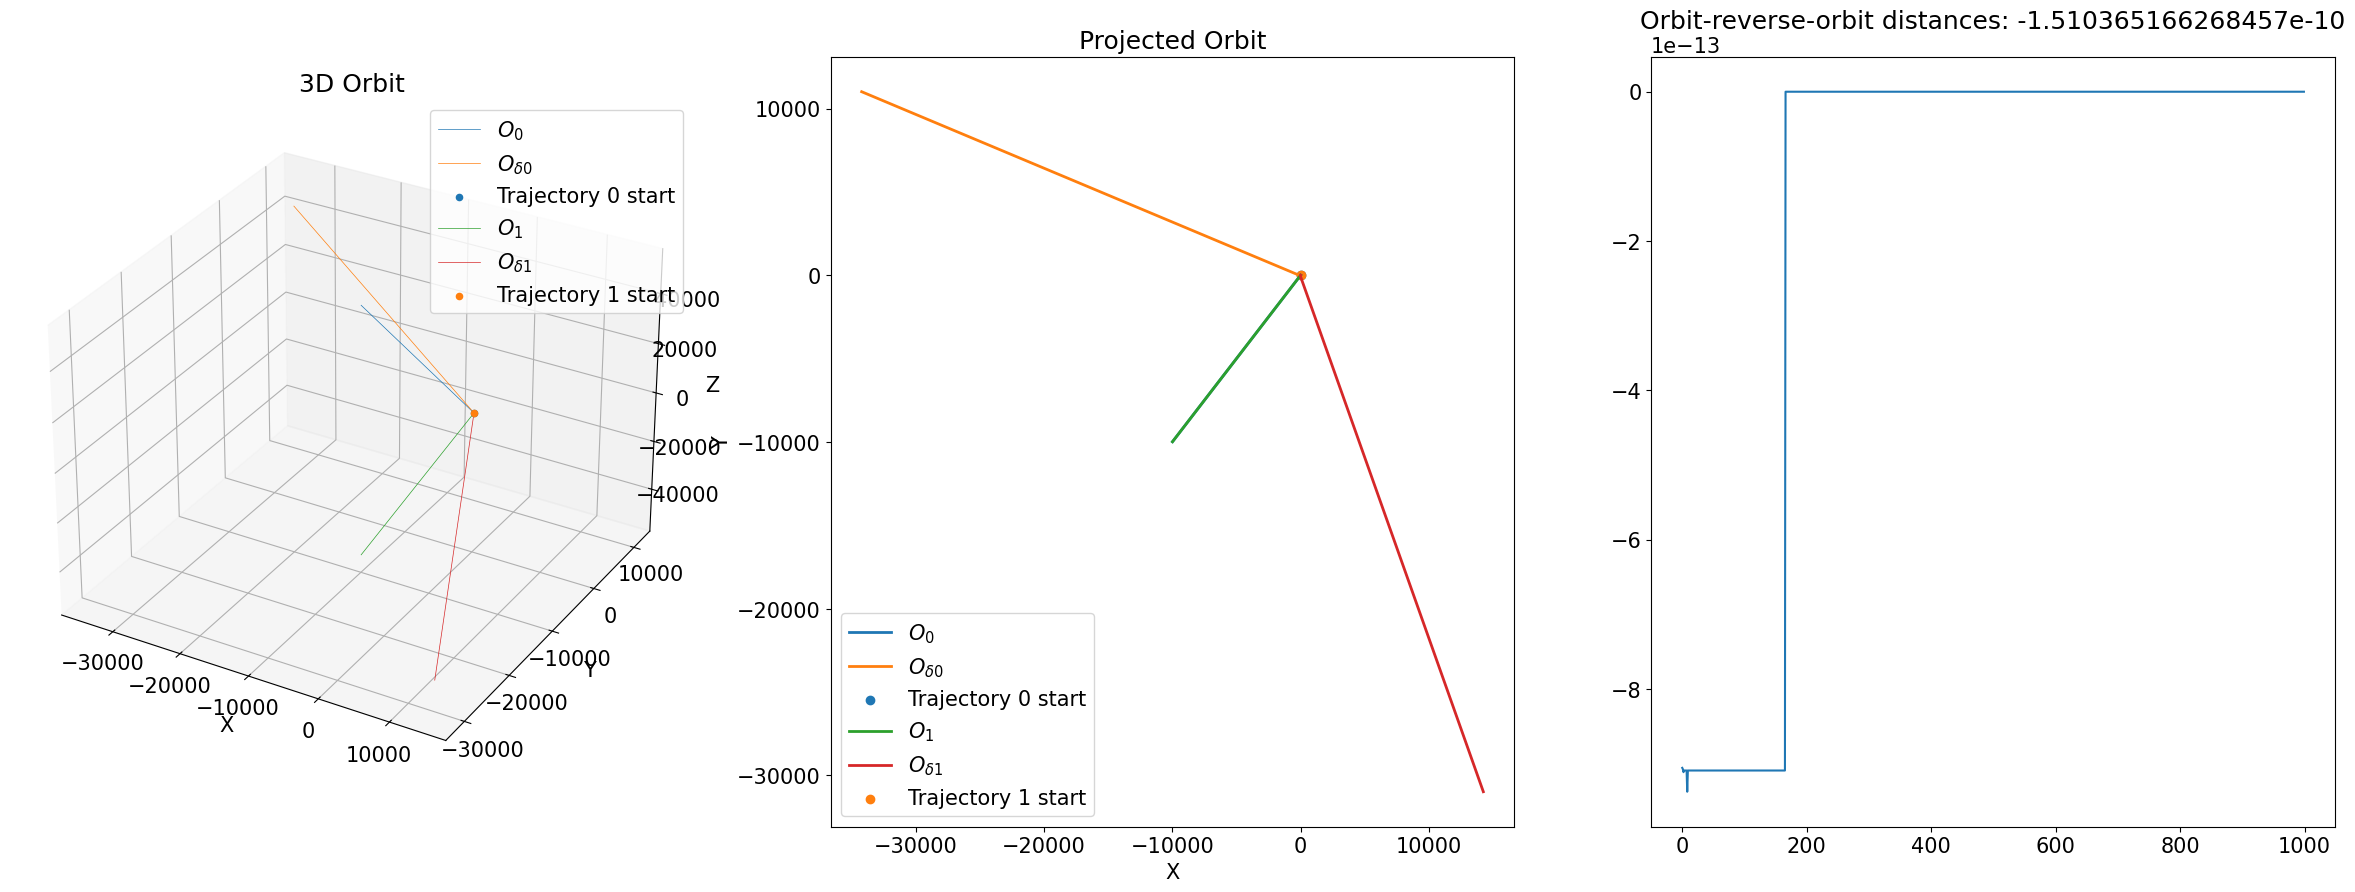

In [10]:
plot_from_init(result_to_init(2))

{0: np.float64(6.35587021570531e-05), 1: np.float64(6.248553285444036e-05)}
{0: array([ -2111.12866211, -10000.        , -10000.        ,  -1000.        ,
           70.38613892,  -1000.        ]), 1: array([  380.00949097, 10000.        , 10000.        ,  -550.41766357,
        -925.64959717, -1000.        ])}


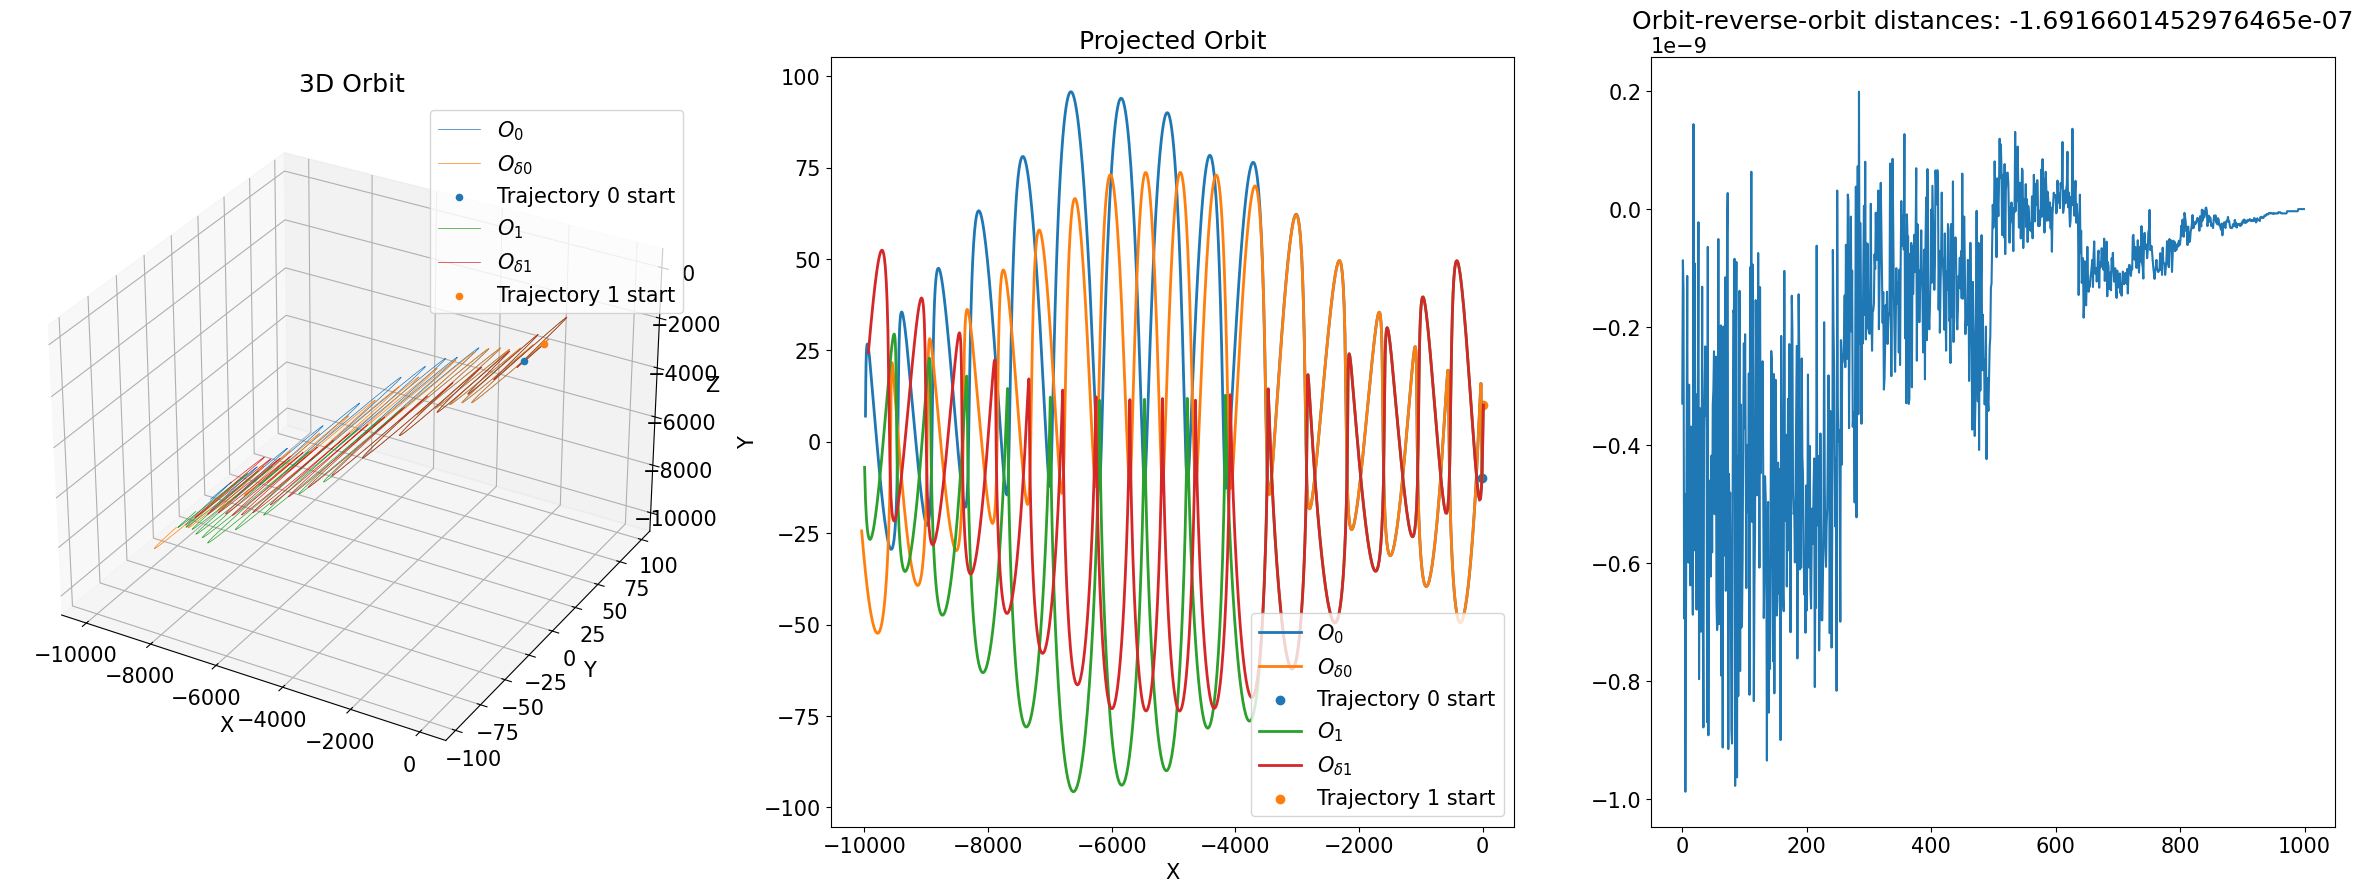

In [11]:
plot_from_init(result_to_init(5))

{0: np.float64(1.106687535401162e-05), 1: np.float64(1.10893992235074e-05)}
{0: array([-10000.        ,  -9344.8984375 ,   4032.02416992,   -610.34851074,
         -644.76135254,   -631.03521729]), 1: array([ 4171.24707031, -2928.65820312, 10000.        ,  -164.08189392,
         234.96806335, -1000.        ])}


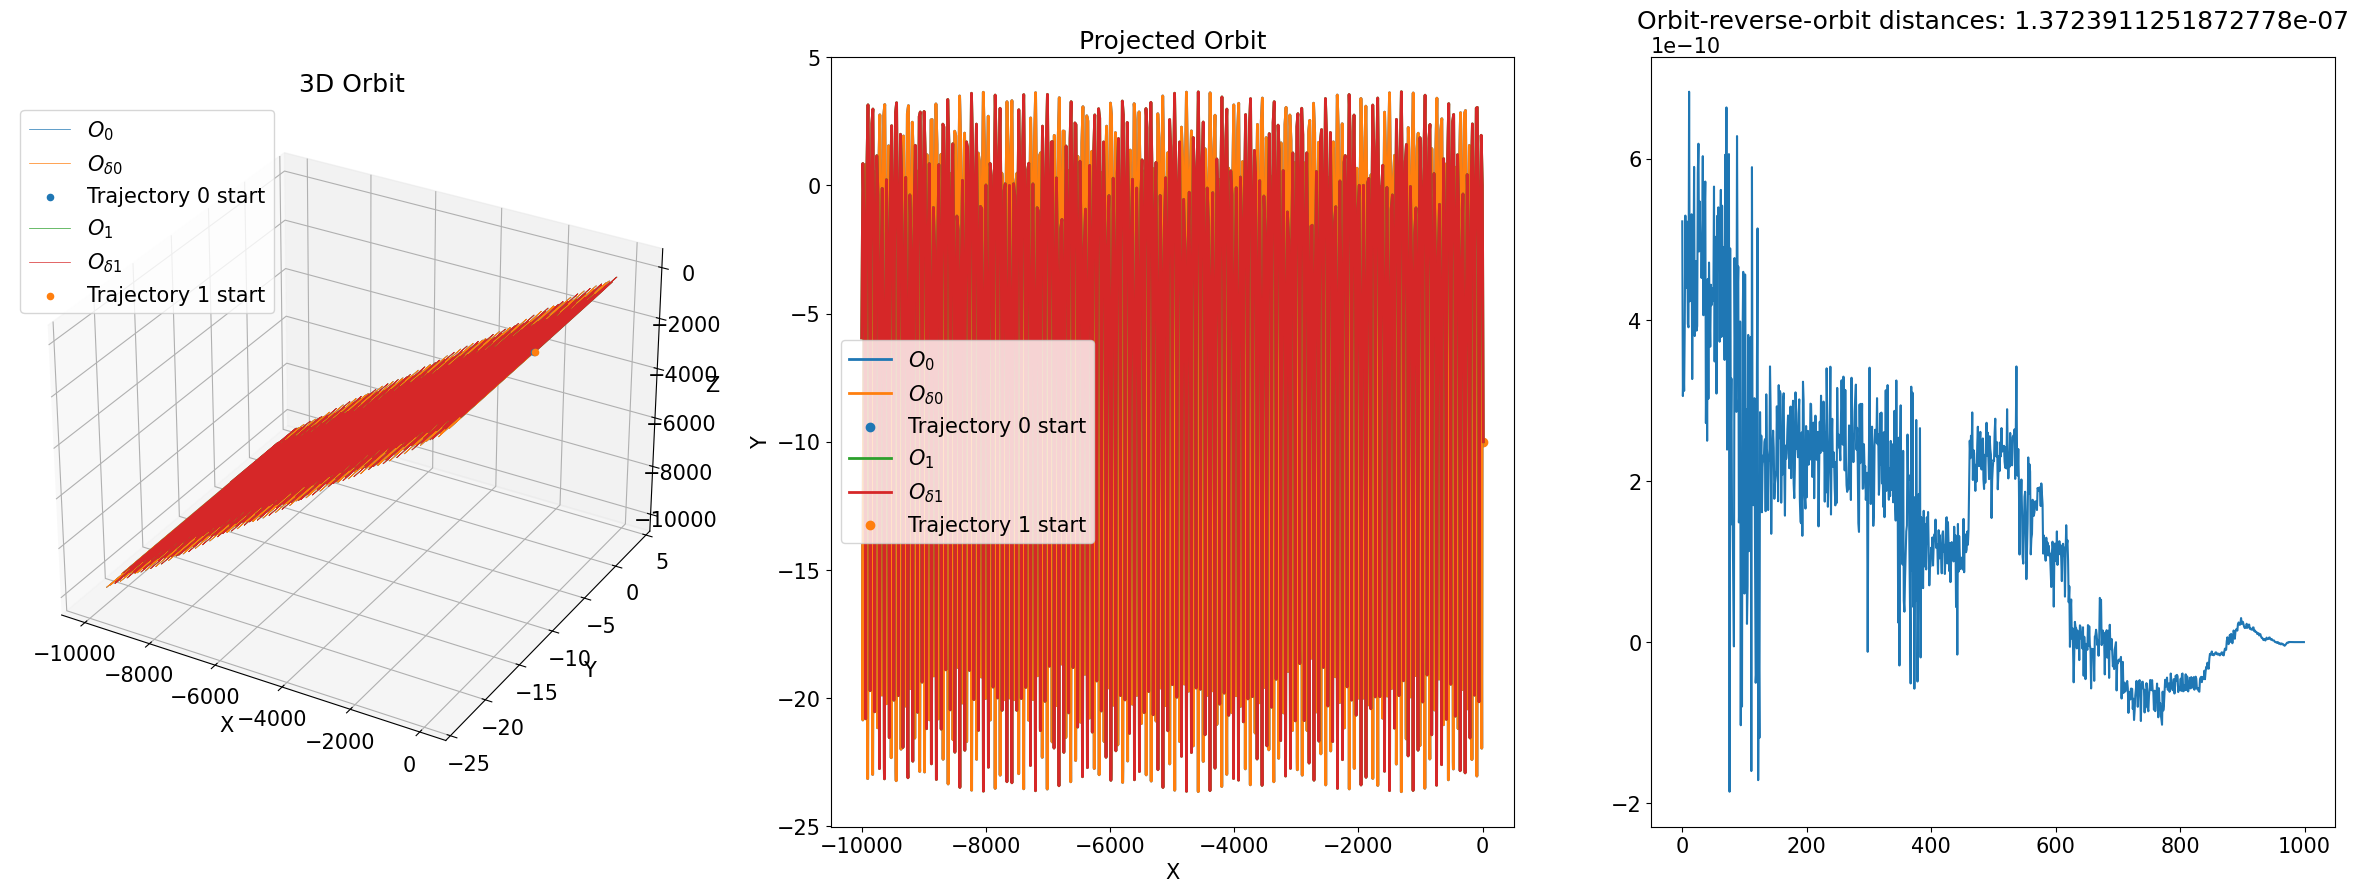

In [12]:
plot_from_init(result_to_init(-1))